In [1]:
%config Completer.use_jedi = False

## Importing the libraries and reading the dataset

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df = pd.read_excel('data_akbilgic.xls',usecols="A:J", skiprows=1, parse_dates=True)
df = df.set_index("date")

In [4]:
df.head()

,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
date,,,,,,,,,
2009-01-05,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
2009-01-06,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2009-01-07,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
2009-01-08,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
2009-01-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [5]:
#target : ISE-> TL Based or ISE.1 -> USD Based . We don't need both so we will keep the USD
df = df.drop('ISE', axis=1)


In [6]:
df = df.rename(columns={'ISE.1': 'ISE'})

## EDA

In [7]:
df.head()

,ISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
date,,,,,,,,
2009-01-05,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
2009-01-06,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2009-01-07,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
2009-01-08,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
2009-01-09,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 536 entries, 2009-01-05 to 2011-02-22
Data columns (total 8 columns):
ISE        536 non-null float64
SP         536 non-null float64
DAX        536 non-null float64
FTSE       536 non-null float64
NIKKEI     536 non-null float64
BOVESPA    536 non-null float64
EU         536 non-null float64
EM         536 non-null float64
dtypes: float64(8)
memory usage: 37.7 KB


In [9]:
#No missing values
df.isna().sum()

ISE        0
SP         0
DAX        0
FTSE       0
NIKKEI     0
BOVESPA    0
EU         0
EM         0
dtype: int64

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ISE,536.0,0.001552,0.021122,-0.084716,-0.009753,0.002643,0.013809,0.100621
SP,536.0,0.000643,0.014093,-0.054262,-0.004675,0.000876,0.006706,0.068366
DAX,536.0,0.000721,0.014557,-0.052331,-0.006212,0.000887,0.008224,0.058951
FTSE,536.0,0.000510,0.012656,-0.054816,-0.005808,0.000409,0.007428,0.050323
NIKKEI,536.0,0.000308,0.014850,-0.050448,-0.007407,0.000000,0.007882,0.061229
BOVESPA,536.0,0.000935,0.015751,-0.053849,-0.007215,0.000279,0.008881,0.063792
EU,536.0,0.000471,0.012990,-0.048817,-0.005952,0.000196,0.007792,0.067042
EM,536.0,0.000936,0.010501,-0.038564,-0.004911,0.001077,0.006423,0.047805


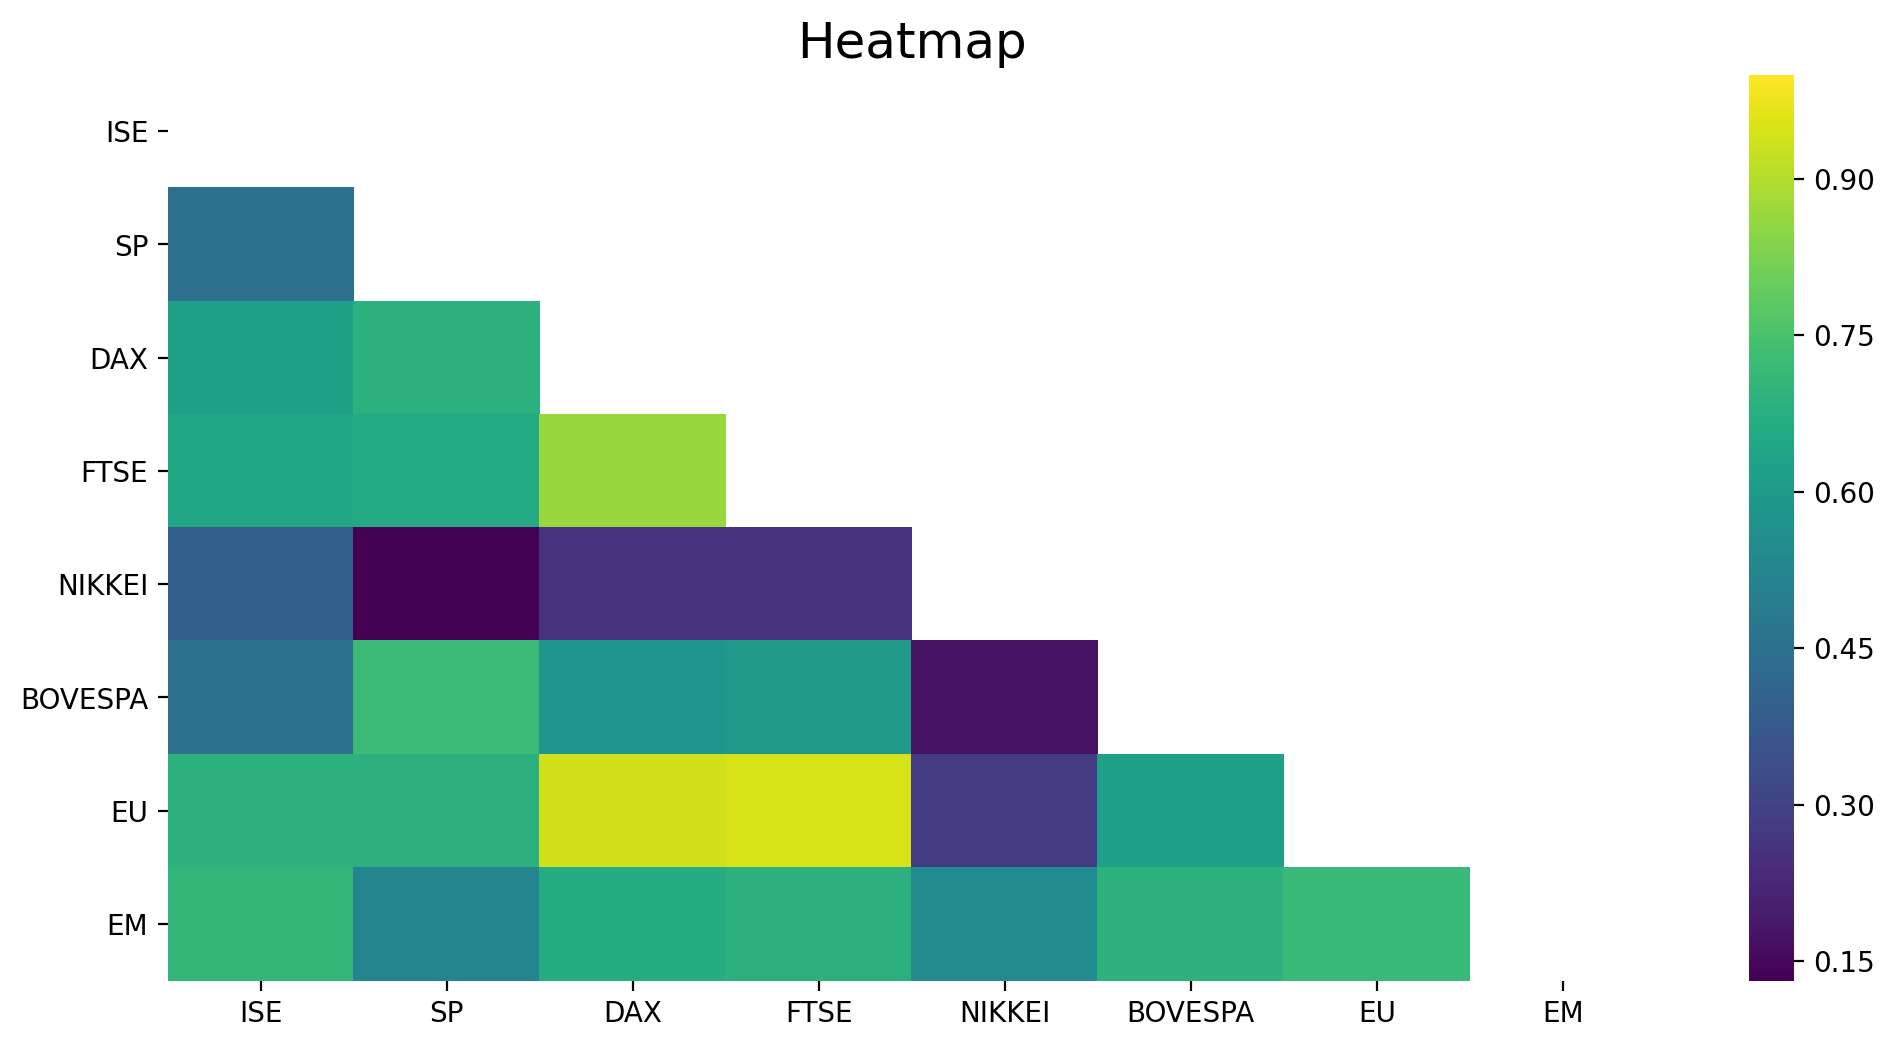

In [11]:
matrix = np.triu(df.corr())

plt.figure(figsize=(12,6),dpi=200)
sns.heatmap(df.corr(), cmap='viridis', mask=matrix);
plt.title('Heatmap', fontsize=18);

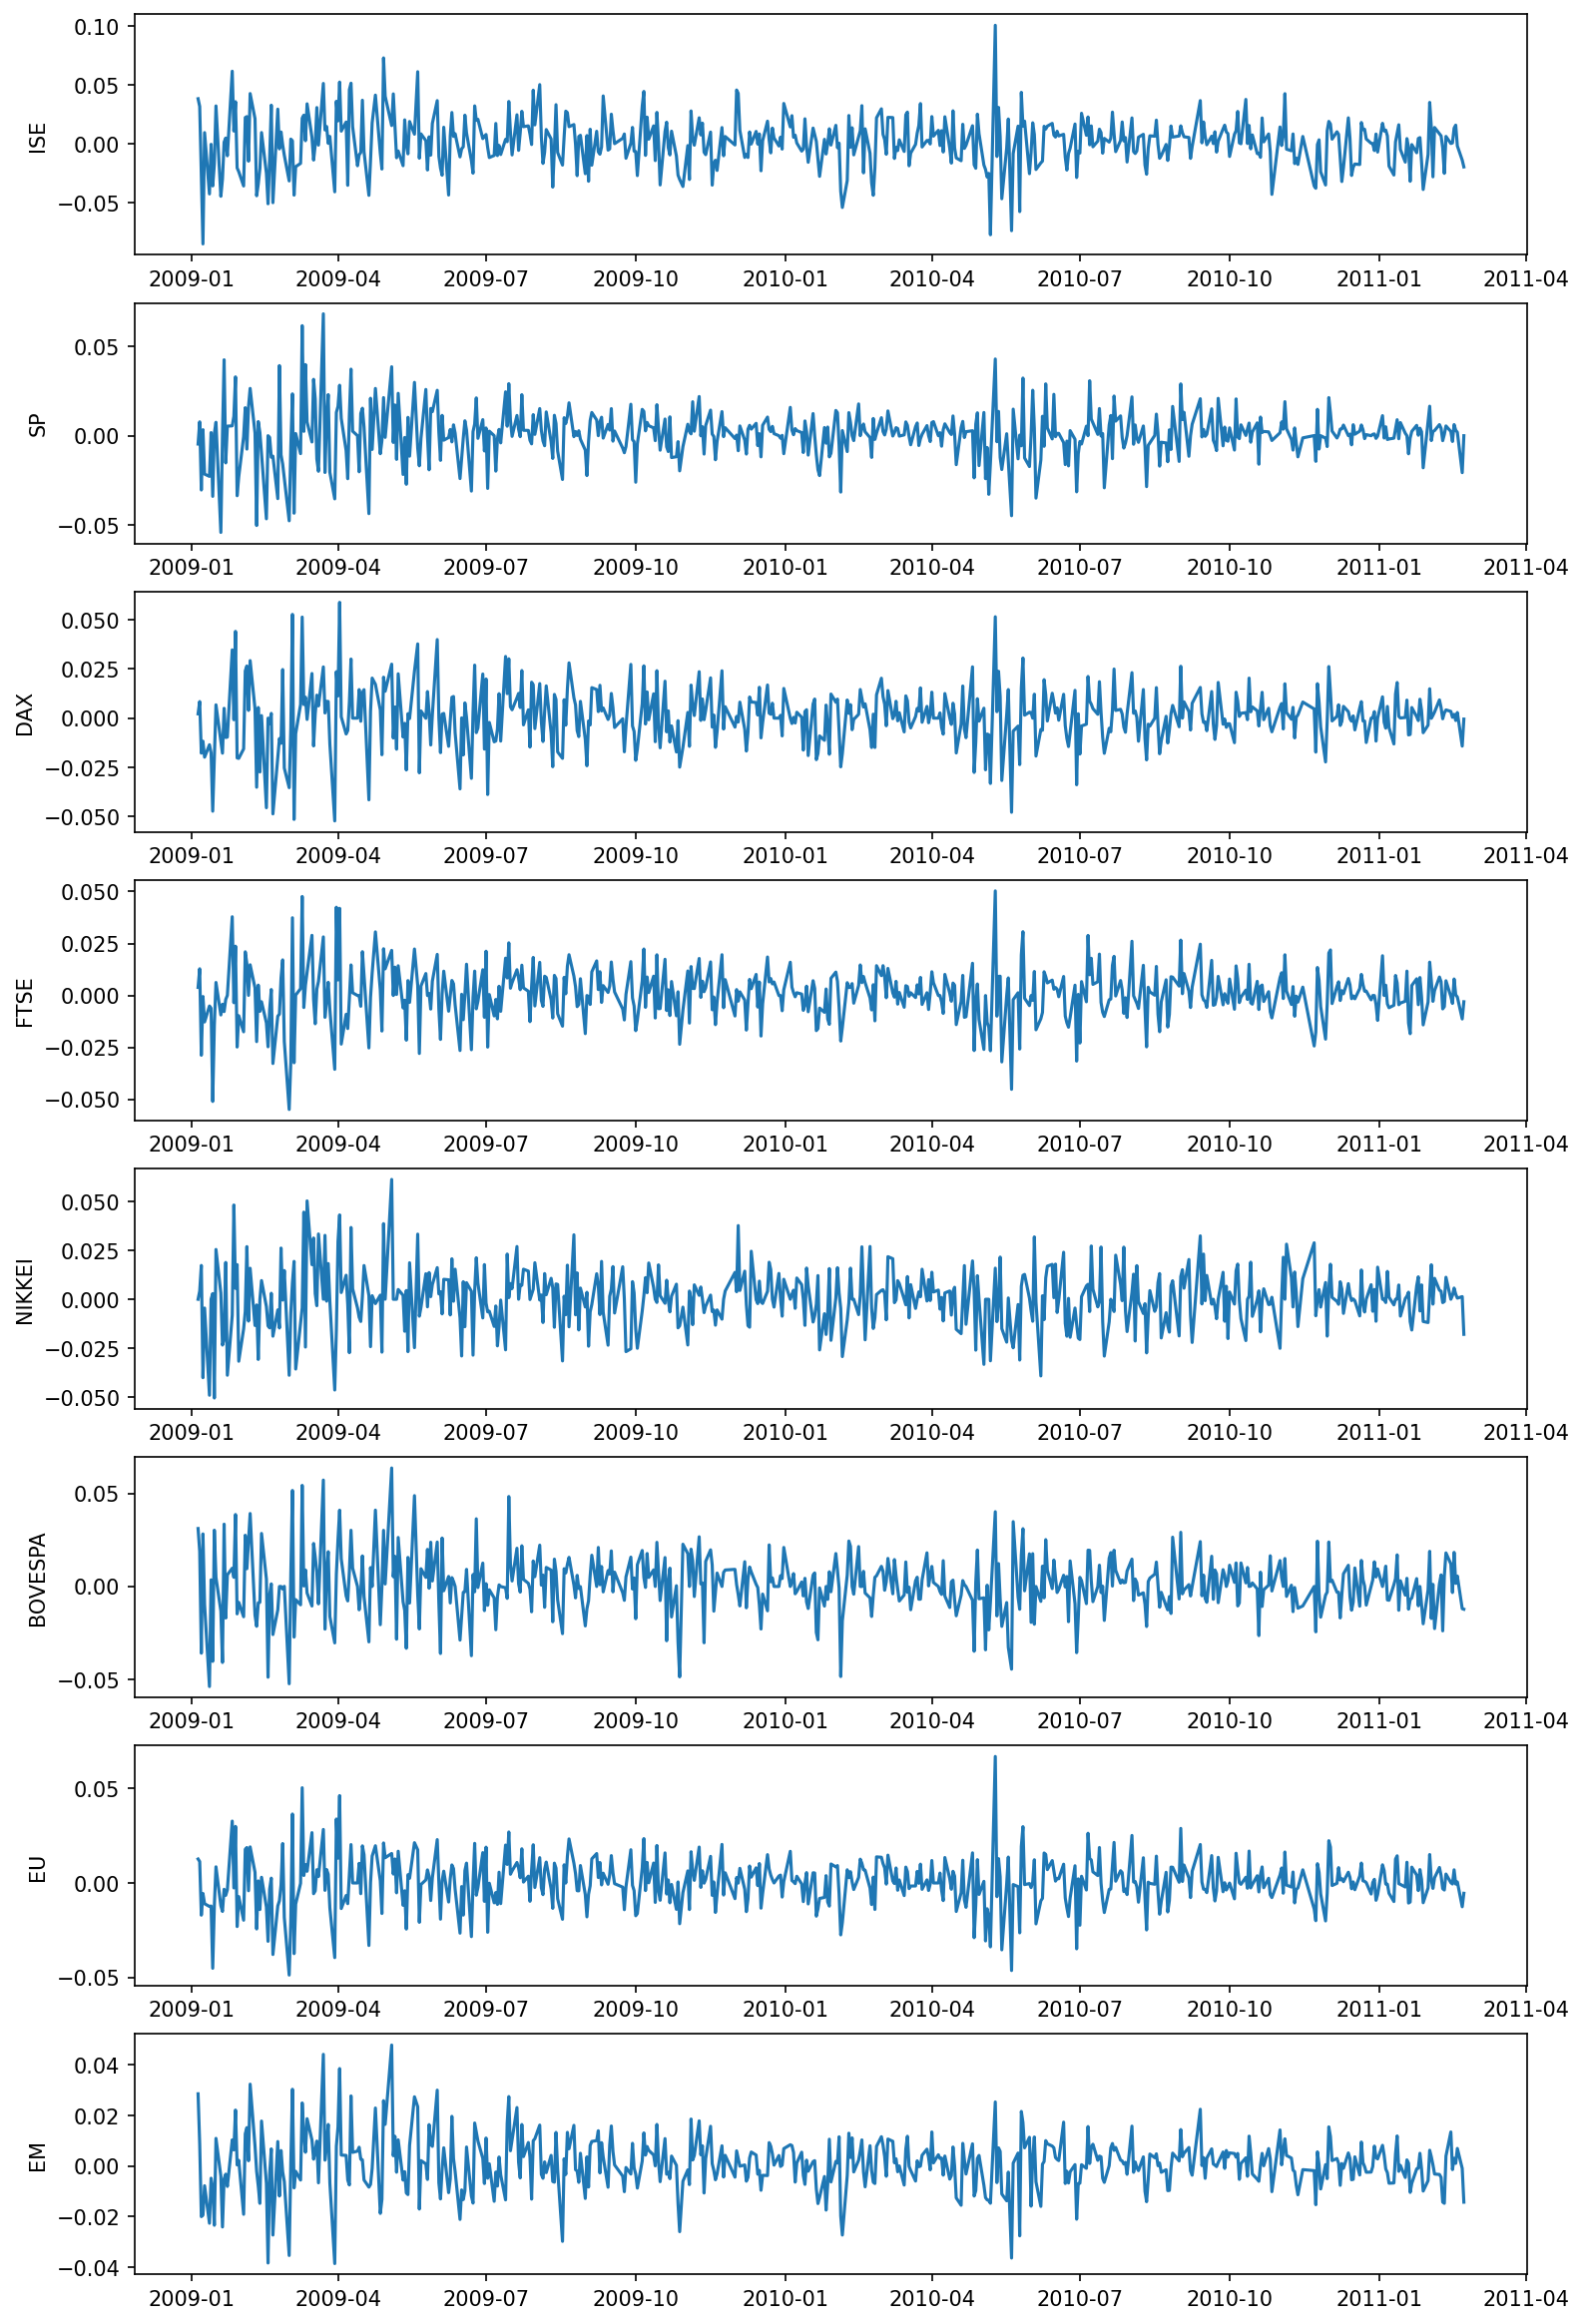

In [14]:
# Plotting all the stocks across time

fig, ax = plt.subplots(nrows=8, figsize=(12,20), dpi=150)
i = 0
for col in df.columns:
    ax[i].plot(df[col])
    ax[i].set_ylabel(col)
    i+=1

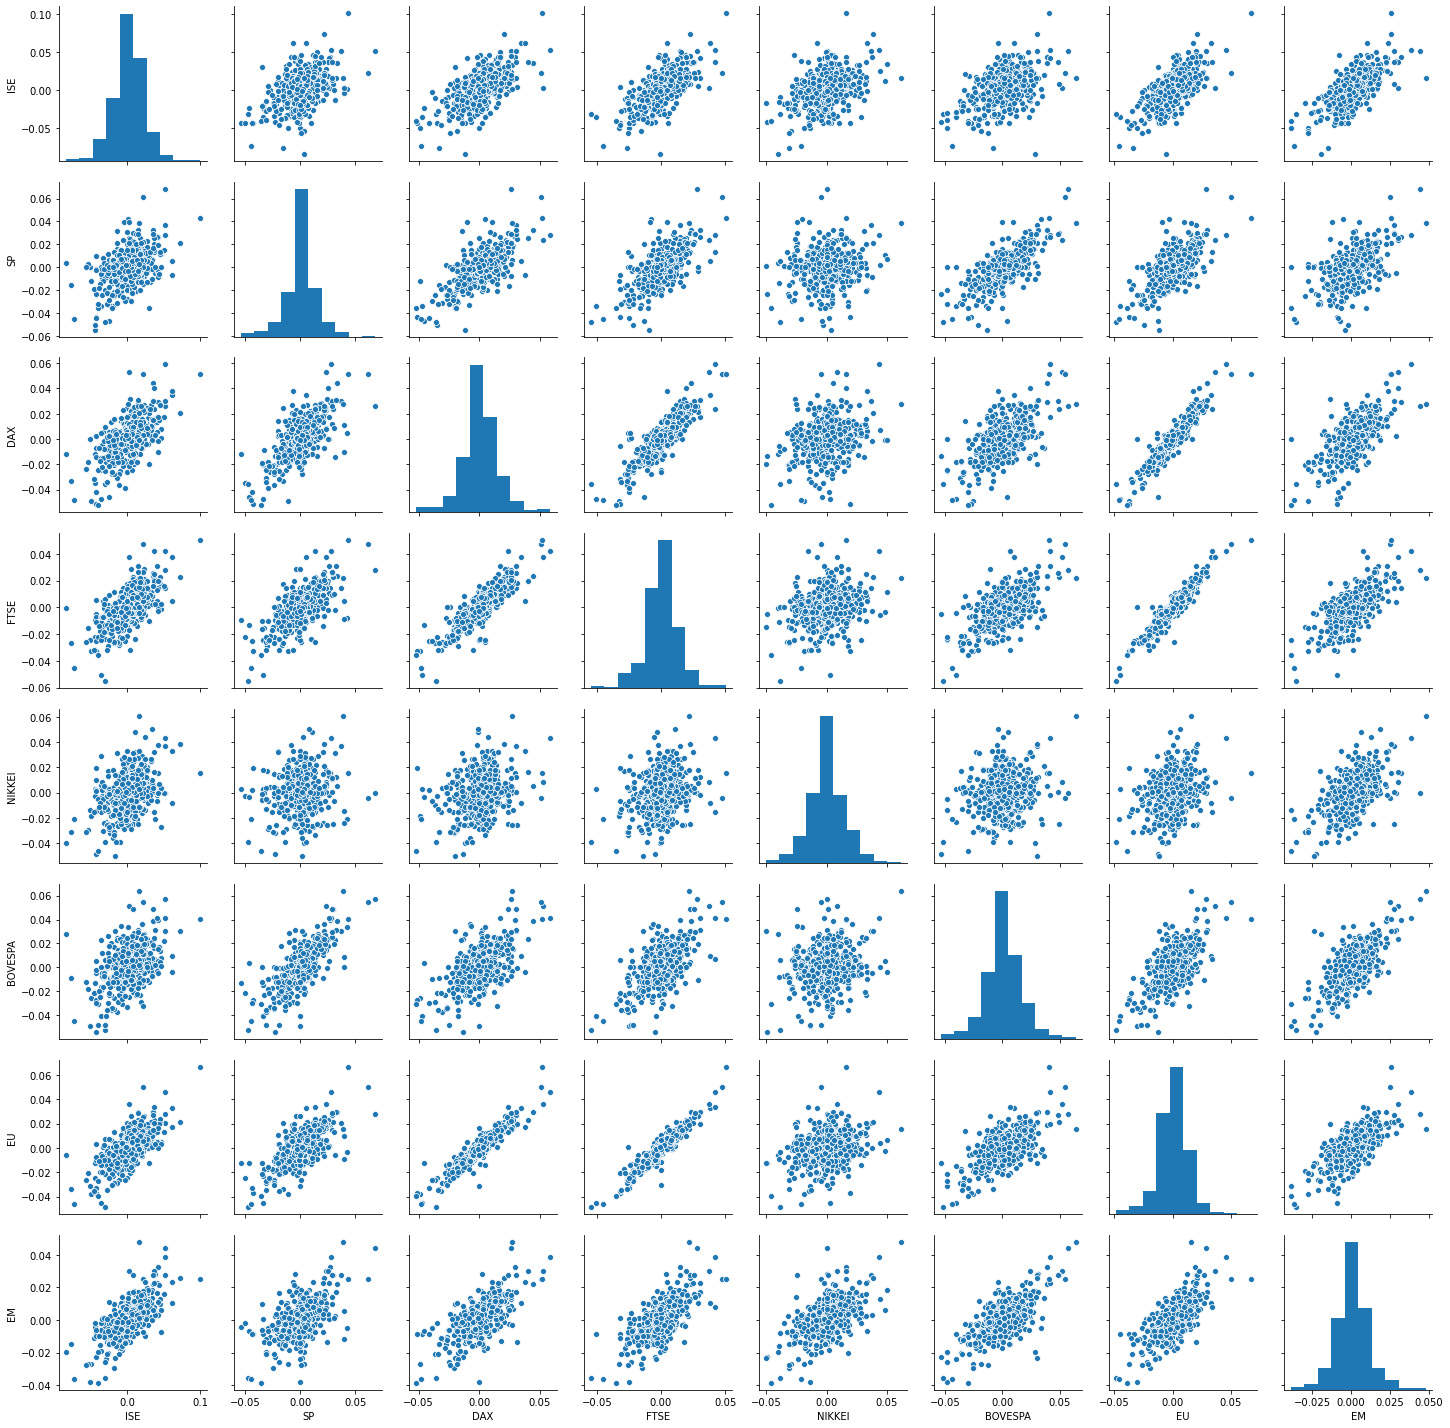

In [15]:
sns.pairplot(df);

## Feature Eng


In [19]:
len(df)

530

In [20]:
df = df.iloc[:530]

In [21]:
len(df)

530

## Simple MLP

In [22]:
features = df.drop('ISE', axis=1).values
labels   = pd.DataFrame(df['ISE']).values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.3,random_state=101)

##### Scale Data

In [24]:
scaler = MinMaxScaler()

In [25]:
scaled_X_train = scaler.fit_transform(X_train)

In [26]:
scaled_X_test = scaler.transform(X_test)

##### Model Creation

In [29]:
ann_model = Sequential()

ann_model.add(Dense(7,activation='relu'))

#Hidden Layer
ann_model.add(Dense(32,activation='relu'))

ann_model.add(Dense(1))

ann_model.compile(optimizer='adam',loss='mse')

In [30]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [31]:
h = ann_model.fit(x=scaled_X_train,y=y_train,
          validation_data=(scaled_X_test,y_test),
          batch_size=128,
          callbacks=[early_stop],
          epochs=400)

Train on 371 samples, validate on 159 samples
Epoch 1/400
371/371 [==============================] - 1s 2ms/sample - loss: 0.0020 - val_loss: 0.0013
Epoch 2/400
371/371 [==============================] - 0s 38us/sample - loss: 0.0012 - val_loss: 8.9434e-04
Epoch 3/400
371/371 [==============================] - 0s 37us/sample - loss: 9.3164e-04 - val_loss: 8.2891e-04
Epoch 4/400
371/371 [==============================] - 0s 41us/sample - loss: 8.9497e-04 - val_loss: 7.8278e-04
Epoch 5/400
371/371 [==============================] - 0s 43us/sample - loss: 8.1386e-04 - val_loss: 6.9273e-04
Epoch 6/400
371/371 [==============================] - 0s 40us/sample - loss: 7.0888e-04 - val_loss: 6.0717e-04
Epoch 7/400
371/371 [==============================] - 0s 39us/sample - loss: 6.2621e-04 - val_loss: 5.6756e-04
Epoch 8/400
371/371 [==============================] - 0s 44us/sample - loss: 5.9788e-04 - val_loss: 5.6059e-04
Epoch 9/400
371/371 [==============================] - 0s 39us/sample -

371/371 [==============================] - 0s 32us/sample - loss: 2.1344e-04 - val_loss: 2.5237e-04
Epoch 74/400
371/371 [==============================] - 0s 32us/sample - loss: 2.1192e-04 - val_loss: 2.5222e-04
Epoch 75/400
371/371 [==============================] - 0s 32us/sample - loss: 2.1119e-04 - val_loss: 2.5238e-04
Epoch 76/400
371/371 [==============================] - 0s 35us/sample - loss: 2.0900e-04 - val_loss: 2.4983e-04
Epoch 77/400
371/371 [==============================] - 0s 29us/sample - loss: 2.0850e-04 - val_loss: 2.5061e-04
Epoch 78/400
371/371 [==============================] - 0s 27us/sample - loss: 2.0742e-04 - val_loss: 2.5368e-04
Epoch 79/400
371/371 [==============================] - 0s 30us/sample - loss: 2.0683e-04 - val_loss: 2.5194e-04
Epoch 80/400
371/371 [==============================] - 0s 30us/sample - loss: 2.0572e-04 - val_loss: 2.5131e-04


In [184]:
ann_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  56        
_________________________________________________________________
dense_1 (Dense)              multiple                  256       
_________________________________________________________________
dense_2 (Dense)              multiple                  33        
Total params: 345
Trainable params: 345
Non-trainable params: 0
_________________________________________________________________


##### Model Evaluation

In [32]:
losses = pd.DataFrame(h.history)

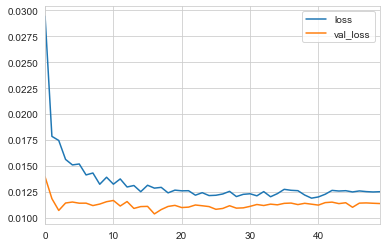

In [176]:
losses.plot()

In [34]:
predictions = ann_model.predict(scaled_X_test)

In [35]:
print("RMSE of the model: ")
np.sqrt(mean_squared_error(y_test,predictions))

RMSE of the model: 


0.015852781741961624

In [187]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

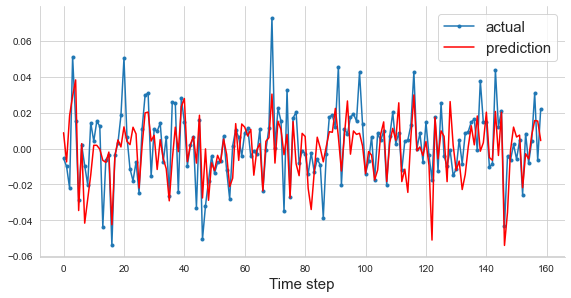

<Figure size 432x288 with 0 Axes>

In [188]:
prediction_plot(y_test, predictions)

## RNN

#### RNN-Train Test Split

In [38]:
test_size = 24 # Last 24 days
test_ind  = len(df)- test_size

In [39]:
train = df[['ISE']].iloc[:test_ind]
test = df[['ISE']].iloc[test_ind:]

### Scale Data

In [40]:
rnn_scaler = MinMaxScaler()

In [41]:
rnn_scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [42]:
scaled_train = rnn_scaler.transform(train)
scaled_test  = rnn_scaler.transform(test)

### Time Series Generator

In [45]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#This class takes in a sequence of data-points gathered at equal intervals,
#along with time series parameters such as stride, length of history, etc.,
#to produce batches for training/validation

In [46]:
length = 12 
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [169]:
model = Sequential()
model.add(SimpleRNN(64, input_shape=(length, n_features), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [170]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, 12, 64)            4224      
_________________________________________________________________
dropout_20 (Dropout)         (None, 12, 64)            0         
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 64)                8256      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 12,545
Trainable params: 12,545
Non-trainable params: 0
_________________________________________________________________


#### Validation Time Series Generator/ Model Training

In [171]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [172]:
model.fit(generator,epochs=50,
                    validation_data=validation_generator,
                    shuffle=False)

Train for 494 steps, validate for 12 steps
Epoch 1/50
494/494 [==============================] - 4s 8ms/step - loss: 0.0294 - val_loss: 0.0139
Epoch 2/50
494/494 [==============================] - 2s 5ms/step - loss: 0.0179 - val_loss: 0.0119
Epoch 3/50
494/494 [==============================] - 2s 5ms/step - loss: 0.0175 - val_loss: 0.0107
Epoch 4/50
494/494 [==============================] - 2s 5ms/step - loss: 0.0156 - val_loss: 0.0114
Epoch 5/50
494/494 [==============================] - 2s 5ms/step - loss: 0.0151 - val_loss: 0.0115
Epoch 6/50
494/494 [==============================] - ETA: 0s - loss: 0.015 - 2s 5ms/step - loss: 0.0152 - val_loss: 0.0114
Epoch 7/50
494/494 [==============================] - 2s 5ms/step - loss: 0.0141 - val_loss: 0.0114
Epoch 8/50
494/494 [==============================] - ETA: 0s - loss: 0.014 - 2s 5ms/step - loss: 0.0143 - val_loss: 0.0112
Epoch 9/50
494/494 [==============================] - 2s 5ms/step - loss: 0.0132 - val_loss: 0.0113
Epoch 10/

In [178]:
losses = pd.DataFrame(model.history.history)

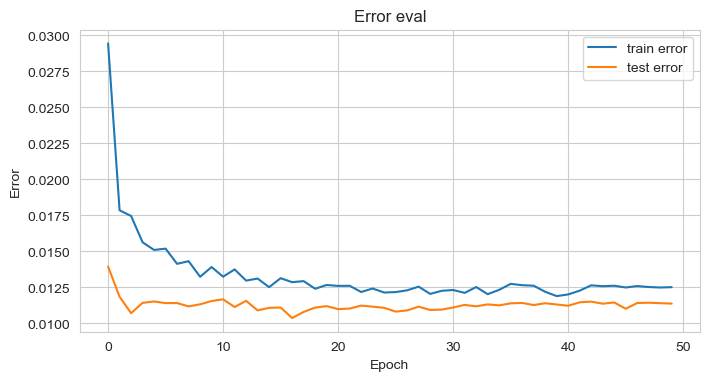

In [179]:
plt.figure(figsize=(8,4), dpi=100)
sns.set_style("whitegrid")
plt.plot(losses["loss"], label="train error")
plt.plot(losses["val_loss"], label="test error")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.title("Error eval");

In [180]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch, batch_size=1)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [181]:
true_predictions = rnn_scaler.inverse_transform(test_predictions)

In [182]:
test['Predictions'] = true_predictions

In [189]:
print("RMSE of the model: ")
np.sqrt(mean_squared_error(test['ISE'],test['Predictions']))

RMSE of the model: 


0.016778894893849226

<AxesSubplot:xlabel='date'>

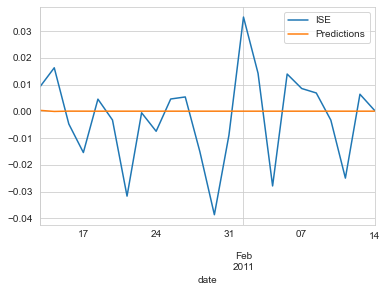

In [190]:
test.plot()